# Pytorch处理数据的API: `Dataset`, `DataLoader`, `Sampler`, `Transforms`

In [1]:
%matplotlib inline

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from IPython.core.debugger import set_trace

# Dataset
创建属于你自己的`Dataset`非常简洁,
除此以外PyTorch提供一些内置数据集
[build-in datasets](https://pytorch.org/docs/stable/torchvision/datasets.html):

- MNIST
- Fashion-MNIST
- KMNIST
- EMNIST
- FakeData
- COCO
  - Captions
  - Detection
- LSUN
- ImageFolder
- DatasetFolder
- Imagenet-12
- CIFAR
- STL10
- SVHN
- PhotoTour
- SBU
- Flickr
- VOC
- Cityscapes

`Dataset` 定义关于这个数据集的一些信息(`__init__`中)、数据集的长度(`__len__`)、抽取一个第index位置的样本(`__getitem__`)，简洁明了。

In [4]:
from torch.utils.data import Dataset

```python
class MyDataset(Dataset):
    def __init__(self, **kwargs):
        pass
    
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
```

`from torchvision.datasets.folder import ImageFolder, default_loader`，图片以文件夹层级关系存储于本地

```
root/dog/1.png
root/dog/2.png
root/dog/3.png
...

root/cat/1.png
root/cat/2.png
root/cat/3.png
...
```

## Example
我们使用一个Kaggle竞赛的数据集讲解[下载地址](https://www.kaggle.com/takjohn/fastai-dogscats)

In [5]:
# %load my_datasets.py
from my_datasets import DogsCatsDataset

In [64]:
train_ds = DogsCatsDataset("../data/raw", "sample/train")

Loading data from ../data/raw/dogscats/sample/train.


In [27]:
#!tree -d ../data/raw/dogscats/
!find ../data/raw/dogscats/ -type d -maxdepth 3

../data/raw/dogscats/
../data/raw/dogscats//valid
../data/raw/dogscats//valid/dogs
../data/raw/dogscats//valid/cats
../data/raw/dogscats//test1
../data/raw/dogscats//sample
../data/raw/dogscats//sample/valid
../data/raw/dogscats//sample/valid/dogs
../data/raw/dogscats//sample/valid/cats
../data/raw/dogscats//sample/train
../data/raw/dogscats//sample/train/dogs
../data/raw/dogscats//sample/train/cats
../data/raw/dogscats//train
../data/raw/dogscats//train/dogs
../data/raw/dogscats//train/cats


In [50]:
train_ds

Dataset DogsCatsDataset
    Number of datapoints: 16
    Root location: ../data/raw/dogscats/sample/train

In [9]:
# the __len__ method
len(train_ds)

16

In [10]:
# the __getitem__ method
train_ds[0]

(<PIL.Image.Image image mode=RGB size=499x375 at 0x111B627F0>, 0)

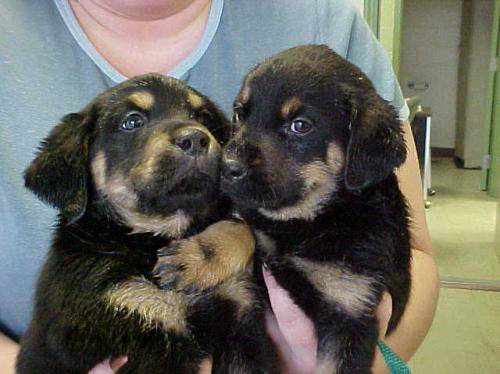

In [11]:
train_ds[14][0]

In [15]:
train_ds[14][1]

1

`这个Dataset中定义一些attributes`

In [17]:
train_ds.classes

['cats', 'dogs']

In [18]:
train_ds.class_to_idx

{'cats': 0, 'dogs': 1}

In [19]:
train_ds.imgs

[('../data/raw/dogscats/sample/train/cats/cat.11737.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.2266.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.2921.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.3570.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.394.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.4600.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.4865.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.9021.jpg', 0),
 ('../data/raw/dogscats/sample/train/dogs/dog.1402.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.1614.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.2423.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.6391.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.6768.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.8091.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.8643.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.9077.jpg', 1)]

In [20]:
import random

0 cats


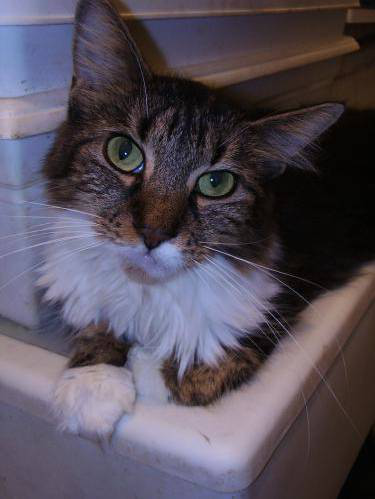

1 dogs


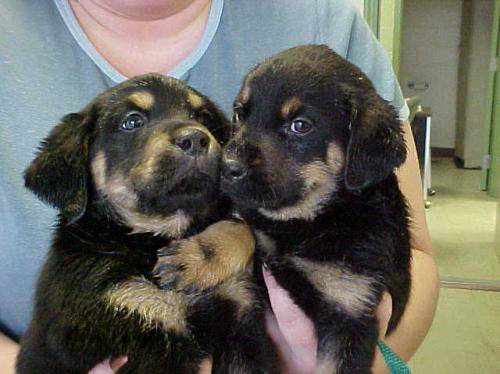

1 dogs


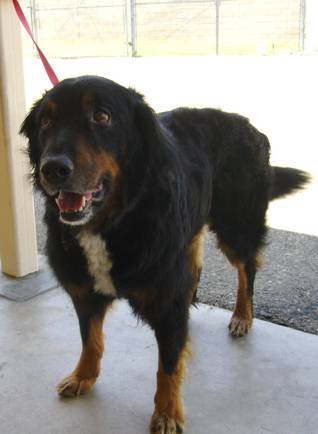

0 cats


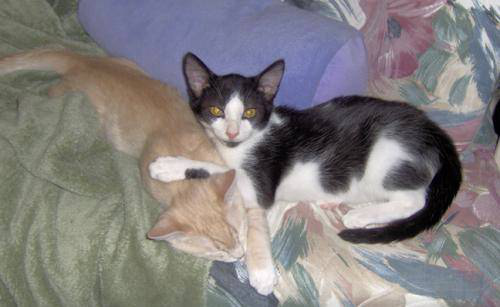

In [21]:
for img, label_id in random.sample(list(train_ds), 4):
    print(label_id, train_ds.classes[label_id])
    display(img)

# `torchvision.transforms`

图像变换方法及组合[[docs]](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [32]:
from torchvision import transforms

In [66]:
_image_size = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


trans = transforms.Compose([
    transforms.RandomCrop(_image_size),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    #transforms.Normalize(_mean, _std),
])

#trans(train_ds[14][0])

# Dataloader
`DataLoader` API提供批加载数据功能（Batch Loading），支持multi-processing、不同的sampling方法[[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

如何创建：
```python
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=default_collate,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None
)
```

In [52]:
from torch.utils.data import DataLoader

In [58]:
train_ds = DogsCatsDataset("../data/raw", "sample/train", transform=trans)
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

Loading data from ../data/raw/dogscats/sample/train.


In [59]:
train_iter = iter(train_dl)
X, y = next(train_iter)

In [60]:
print("X:", X.shape)
print("y:", y.shape)

X: torch.Size([2, 3, 224, 224])
y: torch.Size([2])


注意：我加了图片变换方法`trans`, 返回`torch.Tensor`, 而不是PIL IMAGE（会报错）
`DataLoader`只接受Tensors、数字, 字典、列表格式

In [18]:
_train_ds = DogsCatsDataset("../data/raw", "sample/train", transform=None) 
_train_dl = DataLoader(_train_ds, batch_size=2, shuffle=True)

try:
    for batch in _train_dl:
        pass
except TypeError as e:
    print("ERROR")
    print(e)

Loading data from ../data/raw/dogscats/sample/train.
ERROR
default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


# Sampler
`Sampler`定义抽样方法[[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.sampler.Sampler).

Examples:
- `SequentialSampler`
- `RandomSamples`
- `SubsetSampler`
- `WeightedRandomSampler`

实现你自己的`Sampler`

```python
class Sampler(object):
    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
```

# 总结
- `Dataset`: 抽取一个样本
- `transforms`: 一些图片变换方法（返回前）
- `DataLoader`: 将N个样本组合返回一个BATCH（可以multiprocessing）
- `Sampler`: 抽样方法

# 练习

- 拓展`DogsCatsDataset`，添加样本量读取上限
- `Subset` [[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)创建一个更小的数据集
- `WeightedRandomSampler`假如正负样本不均，使用过采样/下采样

In [19]:
class MyDataSet(Dataset):
    def __init__(self):
        super().__init__()
        # TODO
    
    def __len__(self):
        # TODO
        pass
    
    def __getitem__(self, idx):
        # TODO
        pass